In [1]:
import torch
import os
import numpy as np
import cv2
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda")
print(torch.cuda.is_available())
print(device)

True
cuda


## Data

In [3]:
# chuyển đổi nhãn phù hợp với định dạng yolo
def convert_labels_to_yolo_format (boxes, grid_size=7, num_classes=2):
    label = torch.zeros((grid_size, grid_size, 5 * 2 + num_classes))
    
    for box in boxes:
        cls_id, x, y, w, h = box
        cell_x, cell_y = int(x * grid_size), int(y * grid_size) # ô chịu trách nhiệm có tâm đối tượng
        cell_x_frac, cell_y_frac = x * grid_size - cell_x, y * grid_size - cell_y
        label[cell_x, cell_y, :5] = torch.tensor([cell_x_frac, cell_y_frac, w, h, 1.0], dtype=torch.float32)
        label[cell_x, cell_y, 5:10] = torch.tensor([cell_x_frac, cell_y_frac, w, h, 0.0], dtype=torch.float32)
        label[cell_x, cell_y, 10 + int(cls_id)] = 1.0

    return label # (7, 7, 5 * 2 + 2)

# định nghĩa tập dữ liệu phù hợp với yolo
class YoloDataset(Dataset):
    def __init__ (self, img_dir, label_dir, resize):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg'))]
        self.resize = resize

    def __len__ (self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')

        # ảnh
        # bgr -> rgb -> resize -> normalize
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.resize)
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) # (h, w, c) -> (c, h, w)
        image = torch.tensor(image, dtype=torch.float32)

        # nhãn
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls_id, x, y, w, h = map(float, line.strip().split()[:5])
                    boxes.append([cls_id, x, y, w, h])
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))
        yolo_target = convert_labels_to_yolo_format(boxes)

        return image, yolo_target

In [4]:
train_img_dir = './data/fire/train/images'
train_label_dir = './data/fire/train/labels'
new_size=448

train_dataset = YoloDataset(
    img_dir=train_img_dir,
    label_dir=train_label_dir,
    resize=(new_size, new_size)
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

In [5]:
# kiểm tra Dataloader
images, targets = next(iter(train_loader))
print(f"Số lượng ảnh: {len(images)}")
print(f"Kích thước ảnh: {images[0].shape}")
print(f"Kích thước nhãn: {targets[0].shape}")

Số lượng ảnh: 16
Kích thước ảnh: torch.Size([3, 448, 448])
Kích thước nhãn: torch.Size([7, 7, 12])


cuda:0
cuda:0


ValueError: too many values to unpack (expected 5)

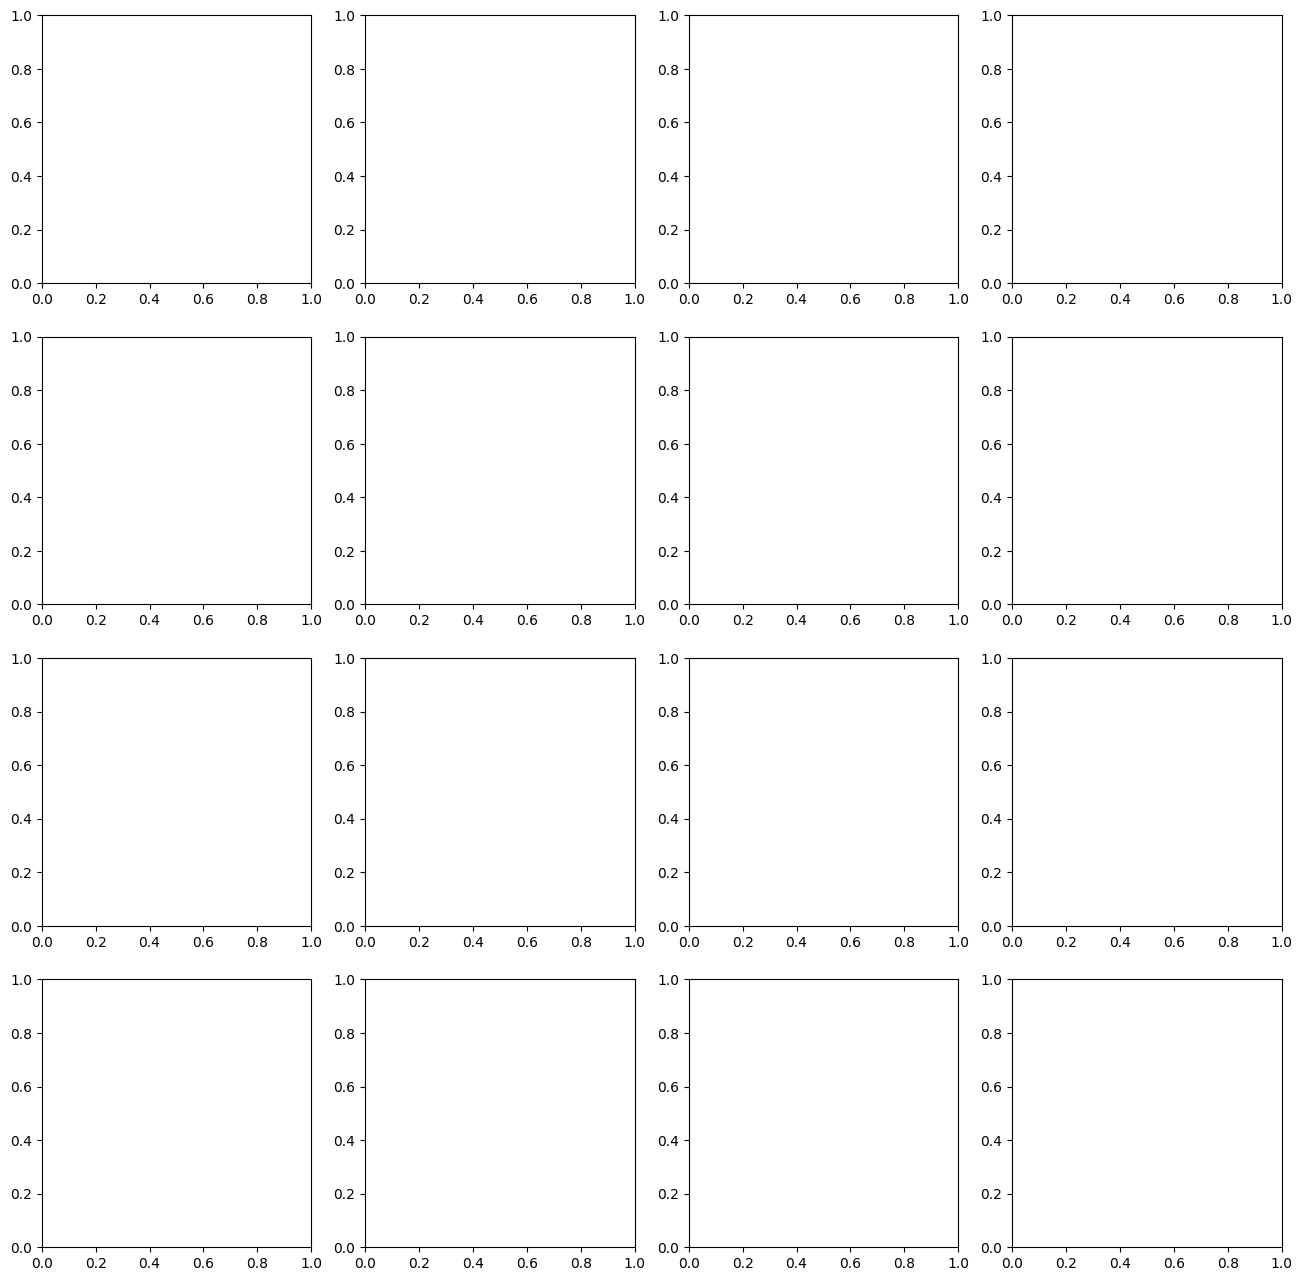

In [ ]:
# in ảnh từ Dataloader
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]
targets = [tgt.to(device) for tgt in targets]
print(images[0].device)
print(targets[0].device)

num_imgs = len(images)
cols = 4
rows = (num_imgs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(rows * 4, cols * 4))

for i, (image, target) in enumerate(zip(images, targets)):
    image_pil = TF.to_pil_image(image) # 
    image_cv = np.array(image_pil)[:,:,::-1].copy()
    h, w = image_cv.shape[:2]

    for box in target:
        cls_id, x, y, w_b, h_b = target[..., 0:5]
        xmin = int((x - w_b/2) * w)
        ymin = int((y - h_b/2) * h)
        xmax = int((x + w_b/2) * w)
        ymax = int((y + h_b/2) * h)
        cv2.rectangle(image_cv, (xmin, ymin), (xmax, ymax), color=(0,255,0), thickness=5)

        label = f"{int(cls_id)}"
        cv2.putText(image_cv, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    r, c = divmod(i, cols)
    ax = axes[r, c] 
    ax.imshow(image_cv[:,:,::-1])
    ax.axis('off')
    ax.set_title(f"Image {i}")


for j in range(num_imgs, rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] 
    ax.axis('off')

plt.tight_layout()
plt.show()

cuda:0
cuda:0


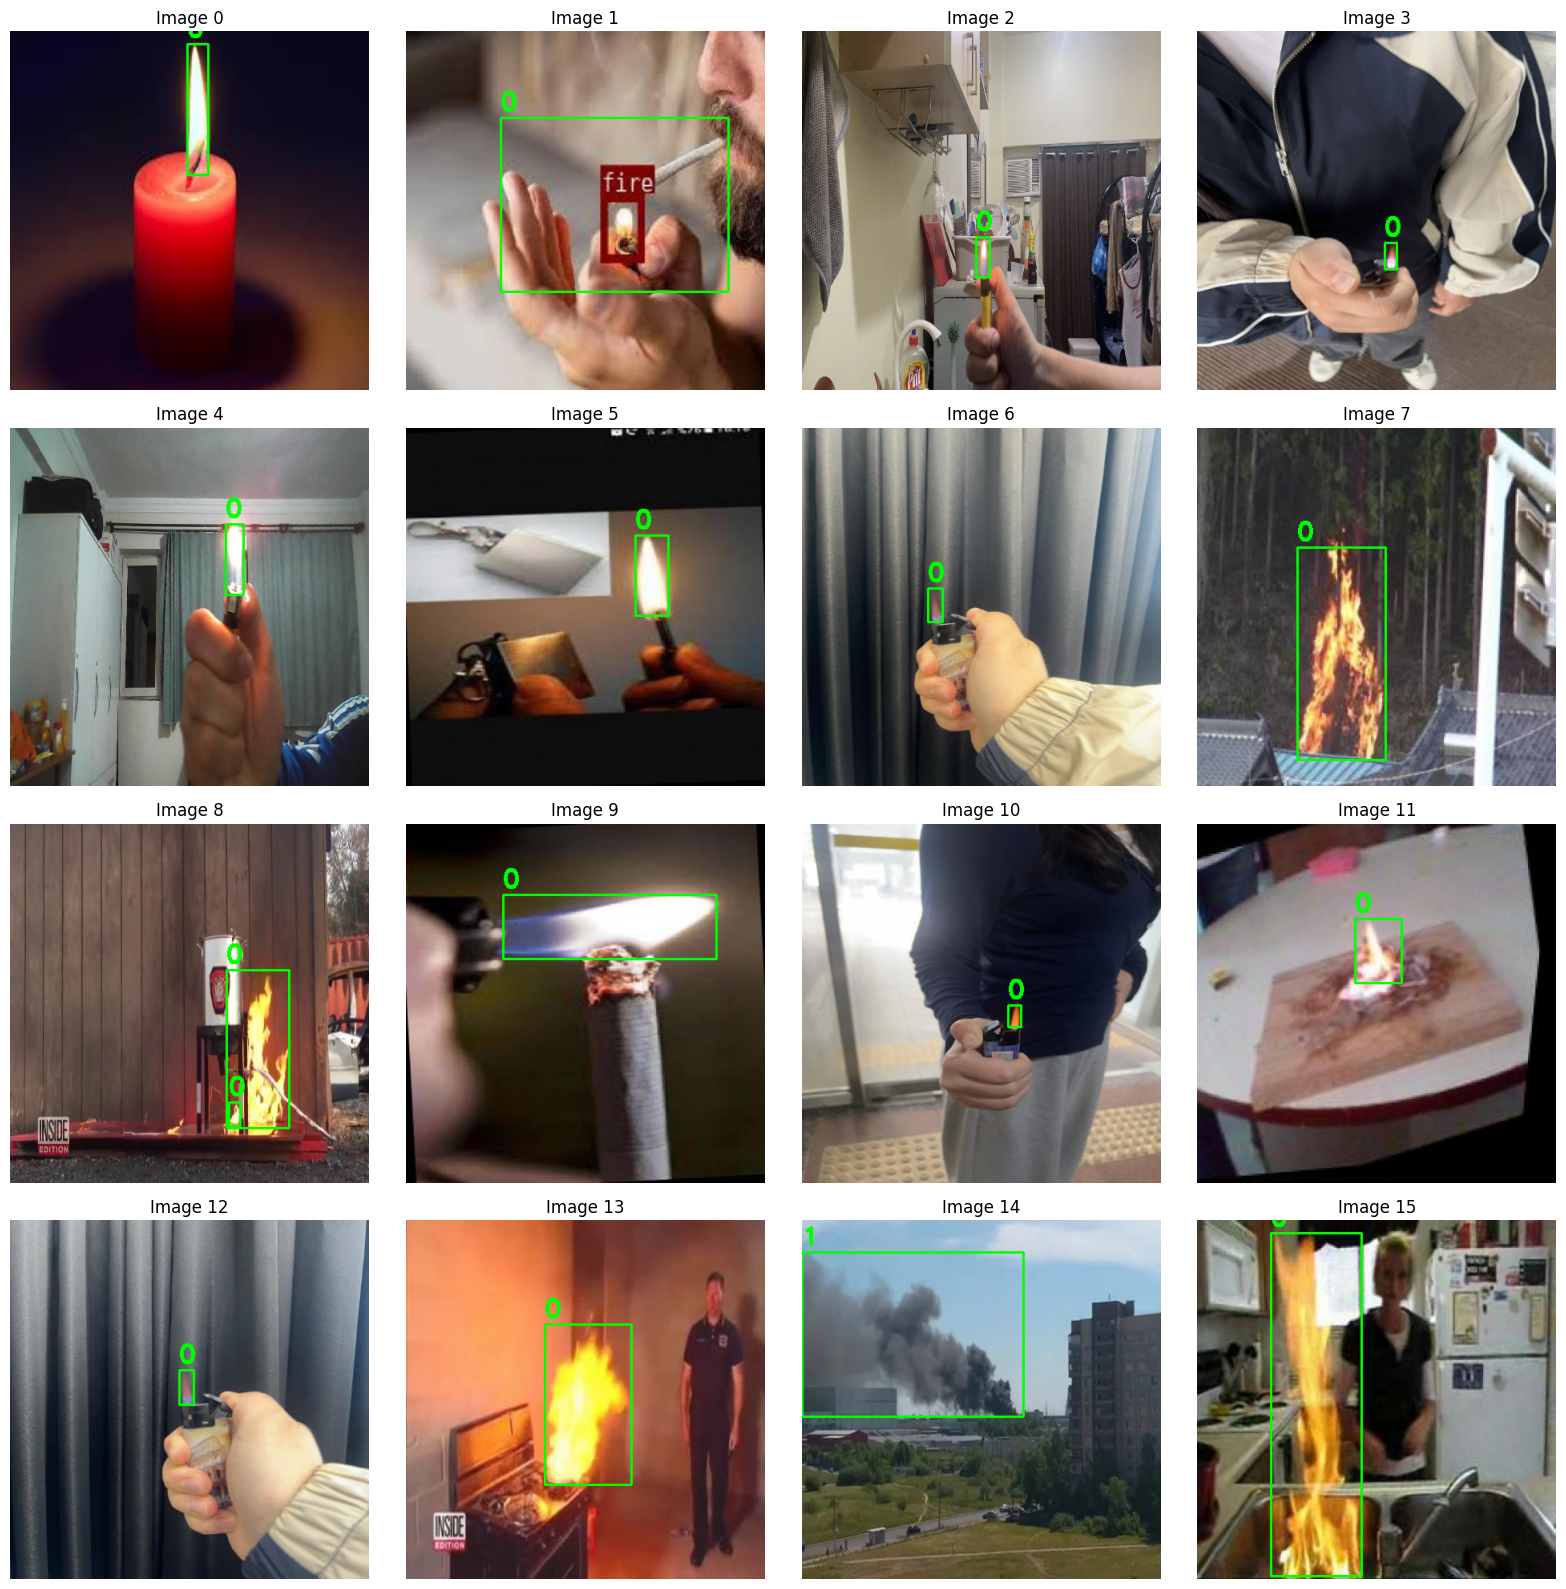

In [9]:
# in ảnh từ Dataloader
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]
targets = [tgt.to(device) for tgt in targets]
print(images[0].device)
print(targets[0].device)

num_imgs = len(images)
cols = 4
rows = (num_imgs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(rows * 4, cols * 4))

for i, (image, target) in enumerate(zip(images, targets)):
    image_pil = TF.to_pil_image(image) 
    image_cv = np.array(image_pil)[:,:,::-1].copy()
    H, W = image_cv.shape[:2]
    S = target.shape[0]

    for ix in range(S):
        for iy in range(S):
            cell = target[ix, iy]

            conf = cell[4].item()

            if conf == 0: continue

            x_frac, y_frac, w_frac, h_frac = cell[0:4].tolist()
            cls_id = int(torch.argmax(cell[10:]))

            abs_x = (ix + x_frac) / S
            abs_y = (iy + y_frac) / S

            xmin = int((abs_x - w_frac/2) * W)
            ymin = int((abs_y - h_frac/2) * H)
            xmax = int((abs_x + w_frac/2) * W)
            ymax = int((abs_y + h_frac/2) * H)

            cv2.rectangle(image_cv, (xmin, ymin), (xmax, ymax), (0,255,0), 2)

            label = f"{int(cls_id)}"
            cv2.putText(image_cv, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    r, c = divmod(i, cols)
    ax = axes[r, c]
    ax.imshow(image_cv[:, :, ::-1])
    ax.axis('off')
    ax.set_title(f"Image {i}")

plt.tight_layout()
plt.show()

## Model

In [25]:
backbone = models.vgg16(pretrained=True) # input: (Batch, 448, 448, 3)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) # output: (Batch, 512, 14, 14)

In [26]:
class YOLOv1(torch.nn.Module):
    def __init__ (self, backbone):
        super().__init__()
        self.backbone = backbone # sequential

        # head
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1), # mở rộng đặc trưng
            torch.nn.LeakyReLU(0.1),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1), # đi sâu hơn vào đặc trưng
            torch.nn.LeakyReLU(0.1)
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024 * 14 * 14, 4096), # kích thước feature map 14*14
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, 7 * 7 * 12) # lưới 7*7*(2 lớp + 5 tham số * 2 boxes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, 7, 7, 12)

## Loss function

In [27]:
def compute_iou(box1, box2):
    # box1: Tensor shape (N, 4), N là số lượng ô có object
    # box format: (xc, yc, w, h)
    box1_xy1 = box1[..., :2] - box1[..., 2:] / 2
    box1_xy2 = box1[..., :2] + box1[..., 2:] / 2
    box2_xy1 = box2[..., :2] - box2[..., 2:] / 2
    box2_xy2 = box2[..., :2] + box2[..., 2:] / 2

    # Intersection
    inter_xy1 = torch.max(box1_xy1, box2_xy1)
    inter_xy2 = torch.min(box1_xy2, box2_xy2)
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    # Area
    box1_area = (box1_xy2[..., 0] - box1_xy1[..., 0]) * (box1_xy2[..., 1] - box1_xy1[..., 1])
    box2_area = (box2_xy2[..., 0] - box2_xy1[..., 0]) * (box2_xy2[..., 1] - box2_xy1[..., 1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)


In [28]:
def yolo_loss(preds, targets, lambda_coord=5, lambda_noobj=0.5):
    """
    Hàm loss cho YOLOv1
    Đầu vào:
        predictions (Tensor): Shape (batch, 7, 7, 12) - Dự đoán của mô hình
        targets (Tensor): Shape (batch, 7, 7, 12) - Ground truth
        lambda_coord (float): Trọng số cho localization loss (tọa độ và kích thước có độ quan trọng lớn hơn)
        lambda_noobj (float): Trọng số cho confidence loss của box không có vật thể
    Đầu ra:
        total_loss (Tensor): Tổng loss
    """

    batch_size = preds.size(0)
    S = 7 # lưới
    B = 2 # anchor boxes mỗi cell

    pred_boxes = preds[..., :10].view(batch_size, S, S, B, 5) # (x, y, w, h, conf) * 2
    target_boxes = targets[..., :10].view(batch_size, S, S, B, 5)
    pred_classes = preds[..., 10:]
    target_classes = targets[..., 10:]

    # đánh dấu ô lưới chứa đối tượng 
    obj_mask = target_boxes[..., 0, 4] > 0
    noobj_mask = ~obj_mask

    # gán trách nhiệm box cho ô chứa đối tượng dự đoán box nào có giá trị iou tốt nhất
    pred_box0 = pred_boxes[..., 0, :4][obj_mask]
    pred_box1 = pred_boxes[..., 1, :4][obj_mask]
    target_box = target_boxes[..., 0, :4][obj_mask]
    iou0 = compute_iou(pred_box0, target_box)
    iou1 = compute_iou(pred_box1, target_box)

    responsible_mask = iou0 > iou1

    pred_box = torch.where(
            responsible_mask.unsqueeze(-1),
            pred_box0,
            pred_box1
        )
    
    # 1. localization loss
    coord_loss = 0
    if obj_mask.sum() > 0:
        # sai số tọa độ
        xy_loss = F.mse_loss(pred_box[..., 0:2], target_box[..., 0:2], reduction='sum')

        # sai số kích thước
        pred_wh = torch.sqrt(pred_box[..., 2:4].clamp(min=0))
        target_wh = torch.sqrt(target_box[..., 2:4])
        wh_loss = F.mse_loss(pred_wh, target_wh, reduction='sum')

        coord_loss = lambda_coord * (xy_loss + wh_loss)

    # 2. confidence loss
    # box chứa vật thể
    conf_obj_loss = 0
    if obj_mask.sum() > 0:
        pred_conf_obj = pred_box[..., 4]
        target_conf_obj = target_box[..., 4][obj_mask]
        conf_obj_loss = F.mse_loss(pred_conf_obj, target_conf_obj, reduction='sum')

    # box không chứa vật thể (tất cả box) 
    pred_conf_noobj = pred_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    target_conf_noobj = target_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    conf_noobj_loss = lambda_noobj * F.mse_loss(pred_conf_noobj, target_conf_noobj, reduction='sum')

    confidence_loss = conf_obj_loss + conf_noobj_loss

    # 3. class loss
    class_loss = 0
    if obj_mask.sum() > 0:
        pred_class = pred_classes[obj_mask]
        target_class = target_classes[obj_mask]
        class_loss = F.mse_loss(pred_class, target_class, reduction='sum')

    # tổng loss
    total_loss = coord_loss + confidence_loss + class_loss
    total_loss /= batch_size  # Chuẩn hóa theo batch size

    return total_loss

## Train

In [31]:
model = YOLOv1(backbone).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3288334336 bytes.

In [ ]:
# check model
input = torch.randn(1,3,448,448).to(device)
with torch.no_grad():
    output = model(input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 7, 7, 12])


In [ ]:
epoch_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader, desc='Training'):
        images = torch.stack([img.to(device) for img in images])
        targets = [tgt.to(device) for tgt in targets]

        optimizer.zero_grad()
        outputs = model(images)
        loss = yolo_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

Training:   0%|          | 0/454 [00:03<?, ?it/s]


TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
torch.save(model.state_dict(), 'yolov1.pth')

## Test
